# View Sod Shock Tube Results

In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
sys.path.append('/Users/smil/Projects/cato/scripts/')
from load_datasets import read_1d_dataset
sns.set_context('talk')

In [ ]:
# -*- coding: utf-8 -*-
"""Read the .h5 files from a simulation into an xarray Dataset"""
import h5py
import numpy as np
import os
import xarray as xr
import pint

ureg = pint.UnitRegistry()


def read_stepfile(file):
    """Read a single .hdf5 file

    Parameters
    ----------
    file : string
        Filename of the hdf5 file

    Returns
    -------
    Dict
        Dictionary of the data from within the hdf5 file
    """
    data = {}

    var_list = ["x", "density", "x_velocity", "y_velocity", "pressure"]

    with h5py.File(file, "r") as h5:
        # Transpose to match the index convention within the code
        data["time"] = h5["/time"][()]
        for var in var_list:
            try:
                data[var] = h5[f"/{var}"][()].T
            except Exception:
                print(f"Unable to read {var}")
    return data


def read_1d_dataset(folder, units="cgs"):
    """[summary]

    Parameters
    ----------
    folder : [type]
        [description]
    units : str, optional
        [description], by default 'cgs'

    Returns
    -------
    [type]
        [description]

    Raises
    ------
    Exception
        [description]
    """

    if units != "cgs" and units != "icf":
        raise Exception("Unsupported units not in the set = {cgs, icf}")

    step_files = sorted(
        [
            os.path.join(folder, f)
            for f in os.listdir(folder)
            if f.endswith(".h5") and f.startswith("step")
        ]
    )
    data = read_stepfile(step_files[0])
    data_dim_x = data["density"].shape[0]
    data_dim_t = len(step_files)

    data = {
        "x": np.zeros((data_dim_t, data_dim_x + 1)),
        "time": np.zeros(data_dim_t),
        "density": np.zeros((data_dim_t, data_dim_x)),
        "pressure": np.zeros((data_dim_t, data_dim_x)),
        "x_velocity": np.zeros((data_dim_t, data_dim_x)),
        "y_velocity": np.zeros((data_dim_t, data_dim_x)),
    }

    for t, f in enumerate(step_files):
        single_step_data = read_stepfile(f)
        data["x"][t, :] = single_step_data["x"][:,0]
        data["time"][t] = single_step_data["time"]
        data["x_velocity"][t, :] = single_step_data["x_velocity"][:,0]
        data["y_velocity"][t, :] = single_step_data["y_velocity"][:,0]
        data["density"][t, :] = single_step_data["density"][:,0]
        data["pressure"][t, :] = single_step_data["pressure"][:,0]

    density = data["density"] * ureg("g/cc")
    pressure = data["pressure"] * ureg("barye")
    x_vel = data["x_velocity"] * ureg("cm/s")
    y_vel = data["y_velocity"] * ureg("cm/s")
    time = data["time"] * ureg("s")
    xc = np.cumsum(np.diff(data["x"][0])) * ureg("cm")

    if units == "cgs":
        density_units = "g/cc"
        pressure_units = "barye"
        vel_units = "cm/s"
        time_units = "s"
        length_units = "cm"

    elif units == "icf":
        density_units = "g/cc"
        pressure_units = "Mbar"
        vel_units = "um/ns"
        time_units = "ns"
        length_units = "um"

    ds = xr.Dataset(
        data_vars={
            "Density": xr.Variable(
                ("time", "x"),
                density.to(density_units).m,
                attrs={"units": density_units},
            ),
            "Pressure": xr.Variable(
                ("time", "x"),
                pressure.to(pressure_units).m,
                attrs={"units": pressure_units},
            ),
            "x_velocity": xr.Variable(
                ("time", "x"), x_vel.to(vel_units).m, attrs={"units": vel_units}
            ),
            "y_velocity": xr.Variable(
                ("time", "x"), y_vel.to(vel_units).m, attrs={"units": vel_units}
            ),
        },
        coords={"time": time.to(time_units).m, "x": xc.to(length_units).m},
    )
    return ds


In [ ]:
data = read_stepfile('step_0000000.h5')

In [ ]:
data['x_velocity'][:,0]

In [ ]:
ds = read_1d_dataset(folder='.', units='cgs')

In [ ]:
# t = 0.012388
# t = 0.001
t=.10018
import sod
import matplotlib.pyplot as plt
gamma = 1.4
npts = 400

positions, regions, values = sod.solve(left_state= (1,       1, 0), 
                                       right_state=(0.1, 0.125, 0.),
                                       geometry=(0., 1., 0.5), 
                                       t=t, gamma=gamma, npts=npts)

p = values['p']
rho = values['rho']
u = values['u']

# Energy and temperature
E = p/(gamma-1.) + 0.5*u**2
T = p/rho


plt.figure(figsize=(18,10))
plt.plot(values['x'], rho, linewidth=1.5, color='r', label='Exact')
plt.ylabel('density')

ds = read_1d_dataset(folder='.', units='cgs')
ds.Density.sel(time=t, method='nearest').plot(label='FVLEG')
plt.legend()
# plt.xlim(.45,.55)
plt.show()

plt.figure(figsize=(18,10))
plt.plot(values['x'], p, linewidth=1.5, color='r', label='Exact')
plt.ylabel('pressure')

ds.Pressure.sel(time=t, method='nearest').plot(label='FVLEG')
plt.legend()
# plt.xlim(.45,.55)
plt.show()

plt.figure(figsize=(18,10))
plt.plot(values['x'], u, linewidth=1.5, color='r', label='Exact')
plt.ylabel('density')

ds.x_velocity.sel(time=t, method='nearest').plot(marker='o',ms=2,label='FVLEG')
plt.legend()
# plt.xlim(.45,.55)
# plt.ylim(.8,1)
plt.show()

In [ ]:
ds['Sound Speed'] = np.sqrt(1.4*ds.Pressure/ds.Density)
ds['Mach Number'] = ds.x_velocity/ds['Sound Speed']

In [ ]:
plt.figure(figsize=(10,10))
# t=.01
ds['Sound Speed'].sel(time=t, method='nearest').plot(marker='o',ms=2,label='cs')
ds['Pressure'].sel(time=t, method='nearest').plot(marker='o',ms=2,label='p')
ds['Density'].sel(time=t, method='nearest').plot(marker='o',ms=2,label='rho')
ds['Mach Number'].sel(time=t, method='nearest').plot(marker='o',ms=2,label='Mach')

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
ds['Mach Number'].sel(time=t, method='nearest').plot(marker='o',ms=2,label='FVLEG')
# plt.ylim(0,2)
plt.axhline(y=1.0)
plt.yticks([.9,1,1.1])
plt.grid()
plt.xlim(0,1)
plt.show()

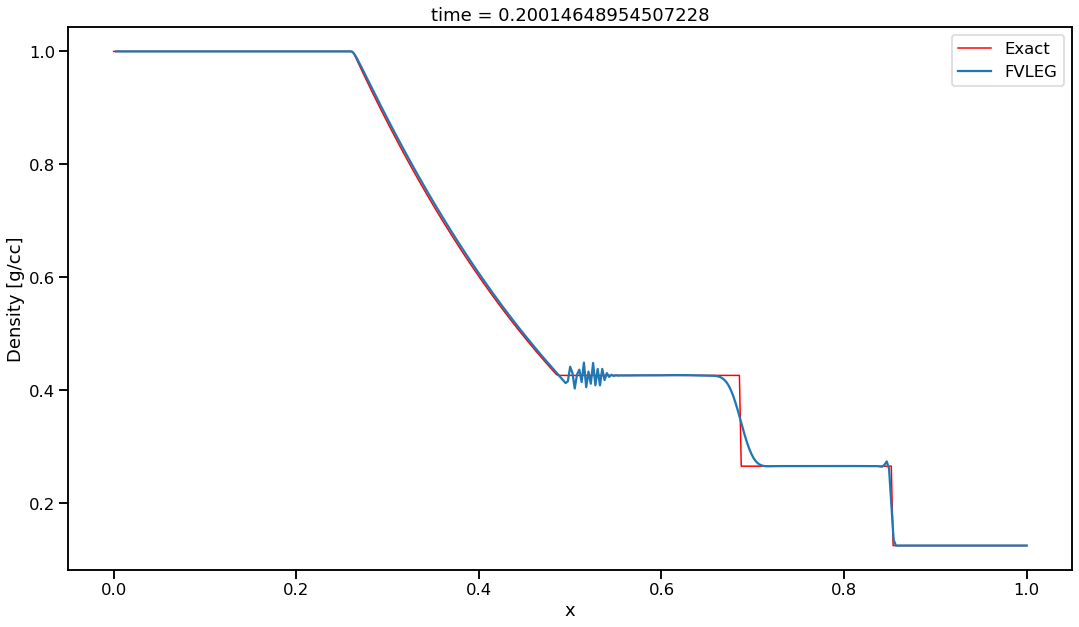

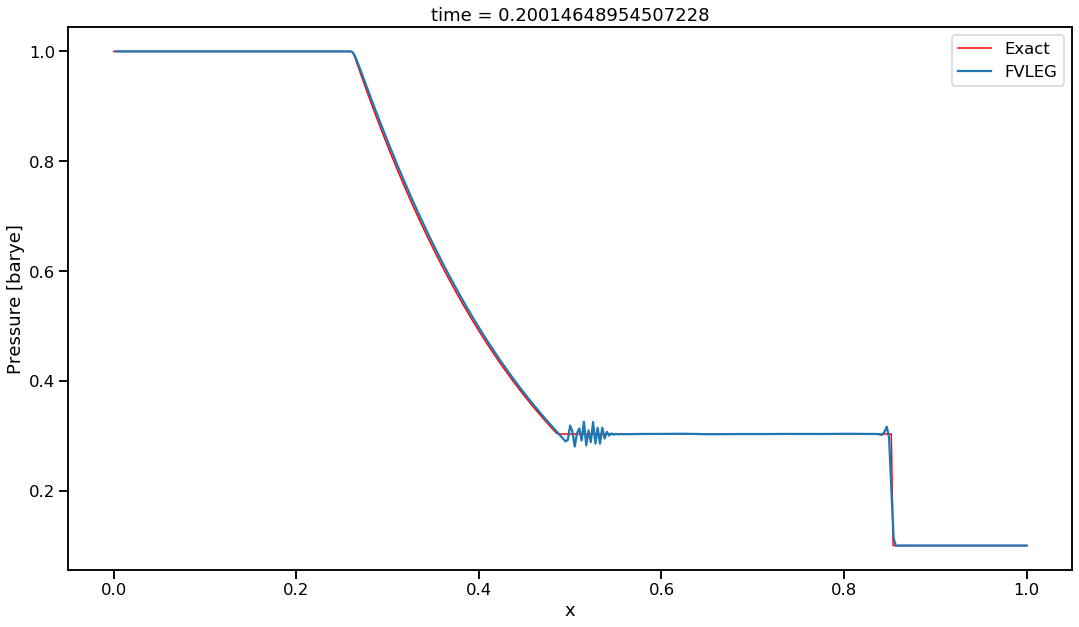

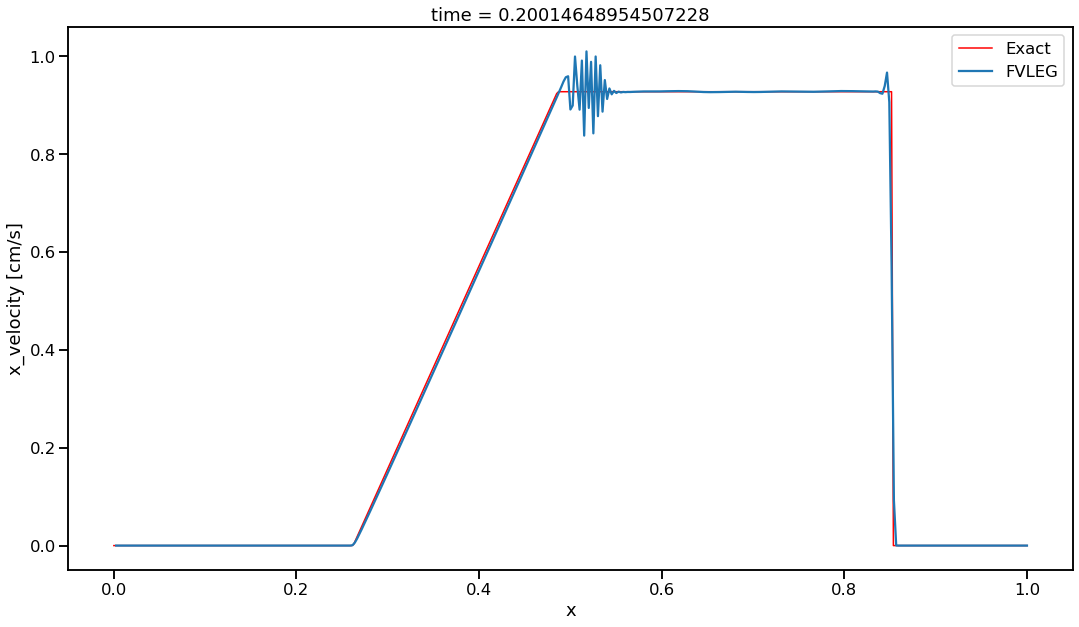

In [24]:
t = 0.2011426

import sod
import matplotlib.pyplot as plt
gamma = 1.4
npts = 500

positions, regions, values = sod.solve(left_state= (1,       1, 0), 
                                       right_state=(0.1, 0.125, 0.),
                                       geometry=(0., 1., 0.5), 
                                       t=t, gamma=gamma, npts=npts)

p = values['p']
rho = values['rho']
u = values['u']

# Energy and temperature
E = p/(gamma-1.) + 0.5*u**2
T = p/rho


plt.figure(figsize=(18,10))
plt.plot(values['x'], rho, linewidth=1.5, color='r', label='Exact')
plt.ylabel('density')

ds = read_1d_dataset(folder='.', units='cgs')
ds.Density.sel(time=t, method='nearest').plot(label='FVLEG')
plt.legend()
plt.show()

plt.figure(figsize=(18,10))
plt.plot(values['x'], p, linewidth=1.5, color='r', label='Exact')
plt.ylabel('pressure')

ds.Pressure.sel(time=t, method='nearest').plot(label='FVLEG')
plt.legend()
plt.show()

plt.figure(figsize=(18,10))
plt.plot(values['x'], u, linewidth=1.5, color='r', label='Exact')
plt.ylabel('density')

ds.x_velocity.sel(time=t, method='nearest').plot(label='FVLEG')
plt.legend()
plt.show()

In [15]:
rho = 1.0
eps = 2e-5/rho
smoothed_rho = eps * (2.0 + rho + 3.0 + 0.5) + (1 - 4*eps) * rho
smoothed_rho

1.00005

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(values['x'], u, linewidth=1.5, color='r', label='Exact')
plt.ylabel('density')

ds = read_1d_dataset(folder='.', units='cgs')
(ds['x_velocity']/ds.Density).sel(time=0.1, method='nearest').plot()

plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(values['x'], p, linewidth=1.5, color='r', label='Exact')
plt.ylabel('density')

ds = read_1d_dataset(folder='.', units='cgs')
ds.Pressure.sel(time=0.1, method='nearest').plot()

plt.show()

In [ ]:
fig, rho_ax = plt.subplots(figsize=(14,6))
p_ax = rho_ax.twinx()

t=4

color = 'r'
ds.Density[t].plot(ax=rho_ax,color=color)
# rho_ax.set_ylabel('Density', color=color)
# rho_ax.tick_params(axis='y', labelcolor=color)

color='b'
ds.Pressure[t].plot(ax=p_ax,color=color)
# p_ax.set_ylabel('Pressure', color=color)
# p_ax.tick_params(axis='y', labelcolor=color)

# v_ax = rho_ax.twinx()
# color='k'
# ds.x_velocity[-1].plot(ax=v_ax, color=color)
# v_ax.set_ylabel('Velocity', color=color)
# v_ax.spines["right"].set_position(("axes", 1.05))
# v_ax.tick_params(axis='y', labelcolor=color)

# plt.xlim(.7,1)
# rho_ax.set_ylim(0,.1)
plt.tight_layout()
plt.show()


In [ ]:
t = 3
plt.figure(figsize=(14,14))
ds.x_velocity[t].plot(label='Velocity')
ds.Energy[t].plot(label='Energy')
ds.Density[t].plot(label='Density')
ds.Pressure[t].plot(label='Pressure')
plt.legend()
plt.show()

In [ ]:
def internal_energy(p,rho,gamma):
    return p/(rho*(gamma-1))

def total_energy(p,rho,u,v,gamma):
    e = internal_energy(p,rho,gamma)
    return e + ((u**2 + v**2)/2.0)


u=0
v=0
# right state
p=.1
rho=.125
E = total_energy(p,rho,u,v,1.4)
print(f'p={p:.3f}, rho={rho:.3f}, E={E:.3f}, rhoE={rho*E:.3f}')

# left state
p=1.0
rho=1.0
E = total_energy(p,rho,u,v,1.4)
print(f'p={p:.3f}, rho={rho:.3f}, E={E:.3f}, rhoE={rho*E:.3f}')

In [ ]:
gamma = 5.0/3.0
tau = 1e-2
p = (3.0/5.0)
rho = 1.0
u = np.sqrt(.7**2 + .7**2)
cs = np.sqrt(gamma * p / rho)
mach = u/cs
radius = cs*tau
print('Mach:',mach, cs)
print('Radius:', radius)